In [18]:
# import
import os
import pandas as pd
import numpy as np
import nibabel as nib
import shutil
from scipy.ndimage import zoom
from joblib import Parallel, delayed
from tqdm import tqdm
import psutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.models as models
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report


ModuleNotFoundError: No module named 'sklearn'

In [2]:
#nii 파일 로드 + 전처리 함수들
# NIfTI 파일 로드
def load_nii(file_path):
    try:
        data = nib.load(file_path).get_fdata(dtype=np.float64)
        if data.ndim == 4 and data.shape[-1] == 1:
            data = data.squeeze(axis=-1)
        elif data.ndim != 3:
            raise ValueError(f"Unexpected data dimensions: {data.shape}. Expected 3D data.")
        return data
    except Exception as e:
        print(f"Error loading NIfTI file {file_path}: {e}")
        return None

# PyTorch 기반 리사이즈 함수
def resize_volume_torch(volume, target_shape=(128, 128, 128)):
    try:
        volume_tensor = torch.tensor(volume, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
        resized = F.interpolate(volume_tensor, size=target_shape, mode='trilinear', align_corners=False)
        return resized.squeeze().numpy()
    except Exception as e:
        print(f"Error resizing volume: {e}")
        return None

# 단일 파일 처리
def process_file(file_name, mmse_score, base_path, target_shape):
    file_path = os.path.join(base_path, file_name)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    volume = load_nii(file_path)
    if volume is None:
        return None

    resized_volume = resize_volume_torch(volume, target_shape)
    if resized_volume is None:
        return None

    return [resized_volume, mmse_score]

# 데이터셋 생성 - Chunking + 병렬 처리
def create_dataset(dataset, base_path, target_shape=(128, 128, 128), chunk_size=20):
    processed_data = []
    total_chunks = len(dataset) // chunk_size + (1 if len(dataset) % chunk_size != 0 else 0)

    # tqdm으로 진행 상황 표시
    with tqdm(total=total_chunks, desc="Processing Dataset") as pbar:
        for i in range(0, len(dataset), chunk_size):
            chunk = dataset[i:i + chunk_size]
            # 병렬 처리
            processed_chunk = Parallel(n_jobs=4)(
                delayed(process_file)(file_name, mmse_score, base_path, target_shape) for file_name, mmse_score in chunk
            )
            # 유효한 데이터만 추가
            processed_data.extend([item for item in processed_chunk if item is not None])
            print(f"{psutil.virtual_memory().percent}%")
            # Progress bar 업데이트
            pbar.update(1)
    return processed_data

In [3]:
#file 받아오고 처리하는 함수들
def get_file_list(folder_path, extension=None):
    try:
        file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and (not extension or f.endswith(extension))]
        return file_list
    except Exception as e:
        print(f"Error getting file list from {folder_path}: {e}")
        return []

def rename_and_copy_files(folder_path, target_folder, extension=None):
    try:
        # 대상 폴더 생성
        os.makedirs(target_folder, exist_ok=True)
        file_list = get_file_list(folder_path, extension)
        for file_name in file_list:
            # 날짜 제거를 위한 파일 이름 분리
            parts = file_name.split(",")
            if len(parts) == 3:
                new_name = f"{parts[0]},{parts[2]}"
                old_path = os.path.join(folder_path, file_name)
                new_path = os.path.join(target_folder, new_name)
                shutil.copy(old_path, new_path)
                print(f"Copied and Renamed: {old_path} -> {new_path}")
    except Exception as e:
        print(f"파일 이름 변경 및 복사 중 에러 발생: {e}")

In [4]:
#renamed 폴더로 이름에 환자번호 - mri번호만 남김 - 날짜 없는 파일에 대한 처리
# folder_path = "niis/ADNI4"  # 폴더 경로를 적어주세요
# target_folder = "niis/ADNI4_renamed"  # 복사할 대상 폴더 경로를 적어주세요
# extension = ".gz"  # 필터링할 확장자를 적어주세요 (예: ".gz")
# rename_and_copy_files(folder_path, target_folder, extension)

In [5]:
def load_metadata_and_files(file_list, metadata, metadata_columns):
    dataset = []
    for file in file_list:
        f = file
        file_parts = file.split('.')[0].split(',')
        if len(file_parts) < 2:
            print(f"Invalid file format: {file}")
            continue
        
        mmse = metadata.loc[
            (metadata[metadata_columns[0]] == file_parts[0]) &
            (metadata[metadata_columns[1]] == file_parts[1]), 
            'MMSCORE'
        ]
        
        mmse_value = mmse.values[0] if not mmse.empty else None
        if mmse_value is not None:
            dataset.append([f, mmse_value])
        else:
            print(f"No matching MMSE score for file: {file}")
    
    return dataset

In [6]:
# 경로 및 데이터 설정
adni3_base_path = 'niis/ADNI3_renamed'
adni4_base_path = 'niis/ADNI4_renamed'

adni3_metadata = pd.read_csv('metadatas/adni3_metadata_cleaned.csv')
adni4_metadata = pd.read_csv('metadatas/adni4_metadata_cleaned.csv')

adni3_file_list = get_file_list(adni3_base_path, extension='.nii.gz')
adni4_file_list = get_file_list(adni4_base_path, extension='.nii.gz')

adni3_dataset = load_metadata_and_files(adni3_file_list, adni3_metadata, ['PTID', 'MRI Number'])
adni4_dataset = load_metadata_and_files(adni4_file_list, adni4_metadata, ['PTID', 'MRI Number'])

No matching MMSE score for file: 002_S_1155,I1270004.nii.gz
No matching MMSE score for file: 020_S_6901,I1412023.nii.gz
No matching MMSE score for file: 021_S_0337,I859989.nii.gz
No matching MMSE score for file: 023_S_6702,I1143230.nii.gz
No matching MMSE score for file: 024_S_6385,I1186714.nii.gz
No matching MMSE score for file: 037_S_4214,I818409.nii.gz
No matching MMSE score for file: 041_S_4874,I884453.nii.gz
No matching MMSE score for file: 053_S_4813,I1251982.nii.gz
No matching MMSE score for file: 082_S_4428,I947589.nii.gz
No matching MMSE score for file: 099_S_6396,I1190195.nii.gz
No matching MMSE score for file: 116_S_4199,I1133016.nii.gz
No matching MMSE score for file: 126_S_6724,I1456875.nii.gz
No matching MMSE score for file: 126_S_7060,I1573346.nii.gz
No matching MMSE score for file: 127_S_6549,I1073644.nii.gz
No matching MMSE score for file: 168_S_6591,I1274614.nii.gz
No matching MMSE score for file: 168_S_6735,I1175356.nii.gz
No matching MMSE score for file: 168_S_6735,

### 데이터셋 생성

In [7]:
# 데이터셋 생성
target_shape = (128, 128, 128)
train_dataset = create_dataset(adni3_dataset, adni3_base_path, target_shape)
test_dataset = create_dataset(adni4_dataset, adni4_base_path, target_shape)

# 디버깅용 출력
for volume, score in train_dataset[:5]:
    print(f"Volume shape: {volume.shape}, MMSE Score: {score}")

Processing Dataset:   1%|          | 1/115 [00:03<07:32,  3.97s/it]

41.5%


Processing Dataset:   2%|▏         | 2/115 [00:06<05:25,  2.88s/it]

42.0%


Processing Dataset:   3%|▎         | 3/115 [00:07<04:26,  2.38s/it]

42.8%


Processing Dataset:   3%|▎         | 4/115 [00:09<03:59,  2.16s/it]

43.0%


Processing Dataset:   4%|▍         | 5/115 [00:11<03:42,  2.03s/it]

43.4%


Processing Dataset:   5%|▌         | 6/115 [00:13<03:32,  1.95s/it]

44.0%


Processing Dataset:   6%|▌         | 7/115 [00:15<03:24,  1.89s/it]

44.5%


Processing Dataset:   7%|▋         | 8/115 [00:16<03:18,  1.86s/it]

44.8%


Processing Dataset:   8%|▊         | 9/115 [00:18<03:18,  1.88s/it]

45.3%


Processing Dataset:   9%|▊         | 10/115 [00:20<03:17,  1.88s/it]

45.8%


Processing Dataset:  10%|▉         | 11/115 [00:22<03:15,  1.88s/it]

46.3%


Processing Dataset:  10%|█         | 12/115 [00:24<03:12,  1.87s/it]

46.5%


Processing Dataset:  11%|█▏        | 13/115 [00:26<03:08,  1.85s/it]

46.9%


Processing Dataset:  12%|█▏        | 14/115 [00:27<02:58,  1.77s/it]

47.5%


Processing Dataset:  13%|█▎        | 15/115 [00:29<02:50,  1.70s/it]

48.0%


Processing Dataset:  14%|█▍        | 16/115 [00:30<02:44,  1.67s/it]

48.3%


Processing Dataset:  15%|█▍        | 17/115 [00:32<02:41,  1.64s/it]

48.8%


Processing Dataset:  16%|█▌        | 18/115 [00:34<02:36,  1.61s/it]

49.3%


Processing Dataset:  17%|█▋        | 19/115 [00:35<02:36,  1.63s/it]

49.8%


Processing Dataset:  17%|█▋        | 20/115 [00:37<02:37,  1.66s/it]

50.3%


Processing Dataset:  18%|█▊        | 21/115 [00:39<02:37,  1.68s/it]

50.9%


Processing Dataset:  19%|█▉        | 22/115 [00:40<02:36,  1.68s/it]

51.2%


Processing Dataset:  20%|██        | 23/115 [00:42<02:38,  1.72s/it]

51.7%


Processing Dataset:  21%|██        | 24/115 [00:44<02:31,  1.66s/it]

52.2%


Processing Dataset:  22%|██▏       | 25/115 [00:45<02:27,  1.64s/it]

52.7%


Processing Dataset:  23%|██▎       | 26/115 [00:47<02:25,  1.63s/it]

53.2%


Processing Dataset:  23%|██▎       | 27/115 [00:49<02:26,  1.67s/it]

53.7%


Processing Dataset:  24%|██▍       | 28/115 [00:51<02:30,  1.73s/it]

54.2%


Processing Dataset:  25%|██▌       | 29/115 [00:52<02:32,  1.78s/it]

54.7%


Processing Dataset:  26%|██▌       | 30/115 [00:54<02:29,  1.76s/it]

55.4%


Processing Dataset:  27%|██▋       | 31/115 [00:56<02:27,  1.76s/it]

55.7%


Processing Dataset:  28%|██▊       | 32/115 [00:57<02:22,  1.72s/it]

56.3%


Processing Dataset:  29%|██▊       | 33/115 [00:59<02:18,  1.69s/it]

56.8%


Processing Dataset:  30%|██▉       | 34/115 [01:01<02:17,  1.69s/it]

57.2%


Processing Dataset:  30%|███       | 35/115 [01:03<02:16,  1.70s/it]

57.8%


Processing Dataset:  31%|███▏      | 36/115 [01:04<02:13,  1.69s/it]

58.3%


Processing Dataset:  32%|███▏      | 37/115 [01:06<02:12,  1.69s/it]

58.8%


Processing Dataset:  33%|███▎      | 38/115 [01:08<02:13,  1.73s/it]

59.2%


Processing Dataset:  34%|███▍      | 39/115 [01:09<02:09,  1.71s/it]

59.8%


Processing Dataset:  35%|███▍      | 40/115 [01:11<02:07,  1.71s/it]

60.3%


Processing Dataset:  36%|███▌      | 41/115 [01:13<02:05,  1.69s/it]

60.5%


Processing Dataset:  37%|███▋      | 42/115 [01:15<02:05,  1.72s/it]

61.0%


Processing Dataset:  37%|███▋      | 43/115 [01:16<02:07,  1.77s/it]

61.5%


Processing Dataset:  38%|███▊      | 44/115 [01:18<02:05,  1.77s/it]

62.0%


Processing Dataset:  39%|███▉      | 45/115 [01:20<02:05,  1.79s/it]

62.5%


Processing Dataset:  40%|████      | 46/115 [01:22<02:02,  1.78s/it]

63.0%


Processing Dataset:  41%|████      | 47/115 [01:24<02:00,  1.77s/it]

63.8%


Processing Dataset:  42%|████▏     | 48/115 [01:26<02:04,  1.87s/it]

64.5%


Processing Dataset:  43%|████▎     | 49/115 [01:28<02:04,  1.89s/it]

65.4%


Processing Dataset:  43%|████▎     | 50/115 [01:29<02:00,  1.86s/it]

65.3%


Processing Dataset:  44%|████▍     | 51/115 [01:31<01:57,  1.83s/it]

65.8%


Processing Dataset:  45%|████▌     | 52/115 [01:33<01:51,  1.76s/it]

66.3%


Processing Dataset:  46%|████▌     | 53/115 [01:34<01:47,  1.73s/it]

66.8%


Processing Dataset:  47%|████▋     | 54/115 [01:36<01:43,  1.70s/it]

67.3%


Processing Dataset:  48%|████▊     | 55/115 [01:38<01:39,  1.67s/it]

67.8%


Processing Dataset:  49%|████▊     | 56/115 [01:39<01:40,  1.70s/it]

68.3%


Processing Dataset:  50%|████▉     | 57/115 [01:41<01:38,  1.70s/it]

68.8%


Processing Dataset:  50%|█████     | 58/115 [01:43<01:39,  1.75s/it]

69.5%


Processing Dataset:  51%|█████▏    | 59/115 [01:45<01:40,  1.79s/it]

69.8%


Processing Dataset:  52%|█████▏    | 60/115 [01:47<01:38,  1.80s/it]

70.3%


Processing Dataset:  53%|█████▎    | 61/115 [01:48<01:37,  1.81s/it]

70.6%


Processing Dataset:  54%|█████▍    | 62/115 [01:50<01:34,  1.78s/it]

71.1%


Processing Dataset:  55%|█████▍    | 63/115 [01:52<01:31,  1.77s/it]

71.6%


Processing Dataset:  56%|█████▌    | 64/115 [01:54<01:29,  1.76s/it]

72.2%


Processing Dataset:  57%|█████▋    | 65/115 [01:55<01:26,  1.74s/it]

72.5%


Processing Dataset:  57%|█████▋    | 66/115 [01:57<01:24,  1.73s/it]

72.7%


Processing Dataset:  58%|█████▊    | 67/115 [01:59<01:22,  1.72s/it]

73.4%


Processing Dataset:  59%|█████▉    | 68/115 [02:00<01:20,  1.72s/it]

73.7%


Processing Dataset:  60%|██████    | 69/115 [02:02<01:19,  1.73s/it]

74.2%


Processing Dataset:  61%|██████    | 70/115 [02:04<01:17,  1.73s/it]

74.7%


Processing Dataset:  62%|██████▏   | 71/115 [02:06<01:15,  1.71s/it]

75.3%


Processing Dataset:  63%|██████▎   | 72/115 [02:07<01:12,  1.68s/it]

75.7%


Processing Dataset:  63%|██████▎   | 73/115 [02:09<01:09,  1.66s/it]

76.2%


Processing Dataset:  64%|██████▍   | 74/115 [02:10<01:07,  1.64s/it]

76.8%


Processing Dataset:  65%|██████▌   | 75/115 [02:12<01:07,  1.69s/it]

77.3%


Processing Dataset:  66%|██████▌   | 76/115 [02:14<01:08,  1.76s/it]

77.7%


Processing Dataset:  67%|██████▋   | 77/115 [02:16<01:08,  1.80s/it]

78.1%


Processing Dataset:  68%|██████▊   | 78/115 [02:18<01:07,  1.81s/it]

78.6%


Processing Dataset:  69%|██████▊   | 79/115 [02:19<01:02,  1.75s/it]

79.1%


Processing Dataset:  70%|██████▉   | 80/115 [02:21<01:00,  1.72s/it]

79.6%


Processing Dataset:  70%|███████   | 81/115 [02:23<00:57,  1.69s/it]

80.1%


Processing Dataset:  71%|███████▏  | 82/115 [02:24<00:55,  1.69s/it]

80.6%


Processing Dataset:  72%|███████▏  | 83/115 [02:26<00:54,  1.70s/it]

81.1%


Processing Dataset:  73%|███████▎  | 84/115 [02:28<00:52,  1.70s/it]

81.6%


Processing Dataset:  74%|███████▍  | 85/115 [02:30<00:50,  1.69s/it]

82.0%


Processing Dataset:  75%|███████▍  | 86/115 [02:31<00:49,  1.70s/it]

82.8%


Processing Dataset:  76%|███████▌  | 87/115 [02:33<00:47,  1.71s/it]

83.1%


Processing Dataset:  77%|███████▋  | 88/115 [02:35<00:46,  1.73s/it]

83.6%


Processing Dataset:  77%|███████▋  | 89/115 [02:37<00:45,  1.73s/it]

83.9%


Processing Dataset:  78%|███████▊  | 90/115 [02:38<00:43,  1.75s/it]

84.4%


Processing Dataset:  79%|███████▉  | 91/115 [02:40<00:42,  1.76s/it]

84.9%


Processing Dataset:  80%|████████  | 92/115 [02:42<00:40,  1.77s/it]

85.4%


Processing Dataset:  81%|████████  | 93/115 [02:44<00:38,  1.75s/it]

86.0%


Processing Dataset:  82%|████████▏ | 94/115 [02:45<00:36,  1.75s/it]

86.5%


Processing Dataset:  83%|████████▎ | 95/115 [02:47<00:35,  1.79s/it]

87.2%


Processing Dataset:  83%|████████▎ | 96/115 [02:49<00:34,  1.80s/it]

87.5%


Processing Dataset:  84%|████████▍ | 97/115 [02:51<00:32,  1.78s/it]

88.0%


Processing Dataset:  85%|████████▌ | 98/115 [02:53<00:30,  1.77s/it]

88.5%


Processing Dataset:  86%|████████▌ | 99/115 [02:54<00:27,  1.73s/it]

89.1%


Processing Dataset:  87%|████████▋ | 100/115 [02:56<00:25,  1.70s/it]

89.4%


Processing Dataset:  88%|████████▊ | 101/115 [02:57<00:23,  1.69s/it]

89.9%


Processing Dataset:  89%|████████▊ | 102/115 [02:59<00:22,  1.73s/it]

90.4%


Processing Dataset:  90%|████████▉ | 103/115 [03:01<00:21,  1.77s/it]

90.7%


Processing Dataset:  90%|█████████ | 104/115 [03:03<00:19,  1.80s/it]

91.5%


Processing Dataset:  91%|█████████▏| 105/115 [03:05<00:18,  1.81s/it]

91.7%


Processing Dataset:  92%|█████████▏| 106/115 [03:07<00:16,  1.81s/it]

92.3%


Processing Dataset:  93%|█████████▎| 107/115 [03:08<00:14,  1.80s/it]

92.8%


Processing Dataset:  94%|█████████▍| 108/115 [03:10<00:12,  1.83s/it]

93.3%


Processing Dataset:  95%|█████████▍| 109/115 [03:12<00:10,  1.83s/it]

93.8%


Processing Dataset:  96%|█████████▌| 110/115 [03:14<00:09,  1.81s/it]

94.1%


Processing Dataset:  97%|█████████▋| 111/115 [03:16<00:07,  1.80s/it]

94.6%


Processing Dataset:  97%|█████████▋| 112/115 [03:18<00:06,  2.05s/it]

95.2%


Processing Dataset:  98%|█████████▊| 113/115 [03:21<00:04,  2.37s/it]

95.6%


Processing Dataset:  99%|█████████▉| 114/115 [03:24<00:02,  2.37s/it]

95.9%


Processing Dataset: 100%|██████████| 115/115 [03:25<00:00,  1.79s/it]


96.2%


Processing Dataset:   8%|▊         | 1/12 [00:01<00:19,  1.80s/it]

96.7%


Processing Dataset:  17%|█▋        | 2/12 [00:04<00:22,  2.29s/it]

96.5%


Processing Dataset:  25%|██▌       | 3/12 [00:06<00:18,  2.02s/it]

97.0%


Processing Dataset:  33%|███▎      | 4/12 [00:08<00:15,  1.97s/it]

96.9%


Processing Dataset:  42%|████▏     | 5/12 [00:10<00:13,  2.00s/it]

96.2%


Processing Dataset:  50%|█████     | 6/12 [00:11<00:11,  1.96s/it]

96.0%


Processing Dataset:  58%|█████▊    | 7/12 [00:13<00:09,  1.94s/it]

96.0%


Processing Dataset:  67%|██████▋   | 8/12 [00:15<00:07,  1.91s/it]

96.1%


Processing Dataset:  75%|███████▌  | 9/12 [00:17<00:05,  1.89s/it]

96.0%


Processing Dataset:  83%|████████▎ | 10/12 [00:19<00:03,  1.87s/it]

96.2%


Processing Dataset:  92%|█████████▏| 11/12 [00:21<00:01,  1.95s/it]

96.1%


Processing Dataset: 100%|██████████| 12/12 [00:23<00:00,  1.95s/it]

96.1%


Volume shape: (128, 128, 128), MMSE Score: 30
Volume shape: (128, 128, 128), MMSE Score: 30
Volume shape: (128, 128, 128), MMSE Score: 30
Volume shape: (128, 128, 128), MMSE Score: 30
Volume shape: (128, 128, 128), MMSE Score: 29


In [8]:
class ADNIDataset(Dataset):
    def __init__(self, dataset, normalization=True):
        self.dataset = dataset
        self.normalization = normalization

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        volume, score = self.dataset[idx]
        volume = torch.tensor(volume, dtype=torch.float32)
        
        if self.normalization:
            volume = (volume - volume.min()) / (volume.max() - volume.min())

        score = torch.tensor(score, dtype=torch.float32)
        return volume, score

In [9]:
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv3d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv3d(64, 128, kernel_size=7, stride=3, padding=3)
        self.bn3 = nn.BatchNorm3d(128)
        self.pool3 = nn.AdaptiveAvgPool3d((1, 1, 1))

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
#3d resnet
resnet3d = models.video.r3d_18(weights=None)

In [10]:
# Train-Val Split
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(len(dataset) * train_ratio)
    val_size = len(dataset) - train_size
    return random_split(dataset, [train_size, val_size])

# 학습 함수
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for volumes, scores in dataloader:
        volumes, scores = volumes.to(device), scores.to(device)

        optimizer.zero_grad()
        outputs = model(volumes)
        loss = criterion(outputs.squeeze(), scores)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(dataloader)

# 평가 함수
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for volumes, scores in dataloader:
            volumes, scores = volumes.to(device), scores.to(device)
            outputs = model(volumes)
            loss = criterion(outputs.squeeze(), scores)
            running_loss += loss.item()
    return running_loss / len(dataloader)

In [11]:
# for TensorBoard
def log_3d_volume_to_tensorboard(writer, volume, step, tag="3D_Volume"):
    # 채널별로 나누기
    num_channels = volume.shape[1]
    for channel in range(num_channels):
        channel_volume = volume[:, channel, :, :, :].detach().cpu().numpy()
        # TensorBoard에 기록 (채널별로 각 축을 이미지로 저장)
        for slice_idx in range(channel_volume.shape[1]):  # Depth 축
            writer.add_image(
                f"{tag}/Channel_{channel}_Slice_{slice_idx}",
                channel_volume[0, slice_idx, :, :],  # 단일 슬라이스
                global_step=step,
                dataformats="HW",  # (Height, Width)
            )

In [17]:
# Hyperparameters
batch_size = 8
learning_rate = 1e-4
epochs = 20

# 데이터 로더 생성
train_dataset = ADNIDataset(train_dataset)
train_set, val_set = split_dataset(train_dataset)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device : ',device)
# 모델, 손실 함수, 옵티마이저 초기화
model = resnet3d.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter(log_dir='logs/12201729')
# 학습 루프
step = 0
for epoch in range(epochs):
    model.train()  # 모델을 학습 모드로 전환
    running_train_loss = 0.0

    for i, (volumes, scores) in enumerate(train_loader):
        volumes = volumes.unsqueeze(1)
        #print(volumes.shape, scores.shape)
        volumes, scores = volumes.to(device), scores.to(device)
        

        optimizer.zero_grad()  # 옵티마이저 초기화
        outputs = model(volumes)  # Forward pass
        loss = criterion(outputs.squeeze(), scores)  # 손실 계산
        loss.backward()  # Backward pass
        optimizer.step()  # 옵티마이저 업데이트

        # TensorBoard 기록 (Train Loss)
        writer.add_scalar("Loss/Train", loss.item(), step)

        running_train_loss += loss.item()
        step += 1

    train_loss = running_train_loss / len(train_loader)

    # Validation 단계
    model.eval()  # 모델을 평가 모드로 전환
    running_val_loss = 0.0

    with torch.no_grad():  # 평가 단계에서는 그래디언트 계산 비활성화
        for volumes, scores in val_loader:
            volumes = volumes.unsqueeze(1)
            volumes, scores = volumes.to(device), scores.to(device)
            outputs = model(volumes)
            loss = criterion(outputs.squeeze(), scores)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(val_loader)

    # TensorBoard 기록 (Validation Loss)
    writer.add_scalar("Loss/Validation", val_loss, epoch)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# TensorBoard 종료
writer.close()

device :  cuda


C:\Users\user\AppData\Local\Temp\ipykernel_30688\2022175092.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volume = torch.tensor(volume, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_30688\2022175092.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score = torch.tensor(score, dtype=torch.float32)


RuntimeError: Given groups=1, weight of size [64, 3, 3, 7, 7], expected input[8, 1, 128, 128, 128] to have 3 channels, but got 1 channels instead

Mean Absolute Error (MAE): 0.2200
Mean Squared Error (MSE): 0.0580
Root Mean Squared Error (RMSE): 0.2408
R² Score: 0.9208


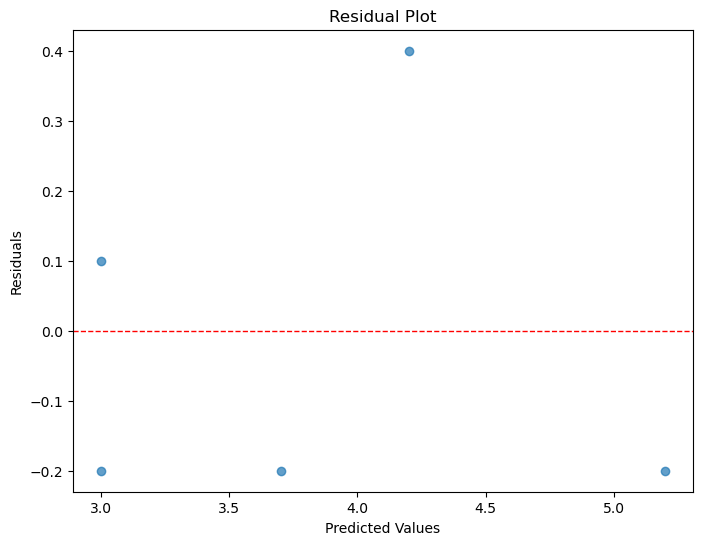

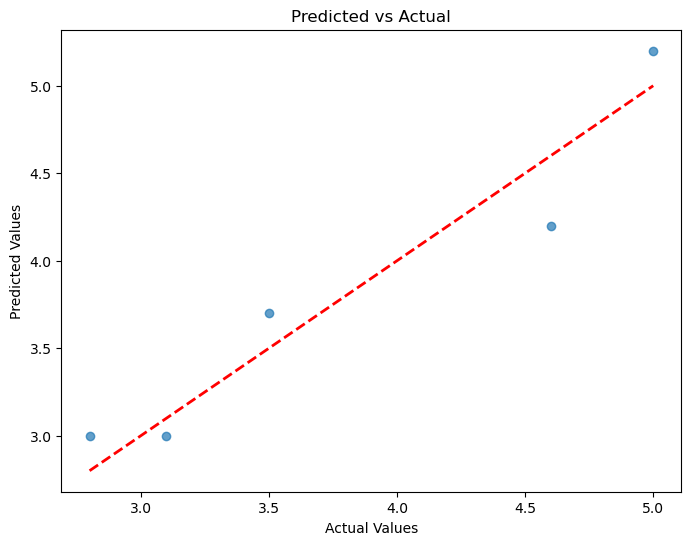

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_regression(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = mse ** 0.5
    r2 = r2_score(true_values, predictions)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# 예측값 계산 후 평가
true_values = [3.5, 2.8, 4.6, 3.1, 5.0]
predictions = [3.7, 3.0, 4.2, 3.0, 5.2]

evaluate_regression(true_values, predictions)
import matplotlib.pyplot as plt

def plot_residuals(true_values, predictions):
    residuals = [true - pred for true, pred in zip(true_values, predictions)]
    plt.figure(figsize=(8, 6))
    plt.scatter(predictions, residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

plot_residuals(true_values, predictions)
def plot_predicted_vs_actual(true_values, predictions):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predictions, alpha=0.7)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

plot_predicted_vs_actual(true_values, predictions)


In [23]:
test_dataset = ADNIDataset(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def evaluate_regression_task(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for volumes, labels in test_loader:
            volumes, labels = volumes.to(device), labels.to(device)
            outputs = model(volumes).squeeze()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to NumPy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Regression metrics
    evaluate_regression(all_labels, all_preds)

    # Visualization
    plot_residuals(all_labels, all_preds)
    plot_predicted_vs_actual(all_labels, all_preds)

# 테스트 데이터셋 평가
evaluate_regression_task(model, test_loader, device)

C:\Users\user\AppData\Local\Temp\ipykernel_30688\2022175092.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volume = torch.tensor(volume, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_30688\2022175092.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score = torch.tensor(score, dtype=torch.float32)


RuntimeError: Given groups=1, weight of size [64, 3, 3, 7, 7], expected input[1, 8, 128, 128, 128] to have 3 channels, but got 8 channels instead